# <h1 align="center">**MULTI-STEP TIME SERIES FORECASTING OF POWER CONSUMPTION:**</h1>

# <h1 align="center">**EVALUATION OF VARIOUS MODELS INCLUDING CNN, LSTM, CNN-LSTM, AND**</h1>

# <h1 align="center">**MULTIPLE LINEAR REGRESSION**</h1>

**Objectives of the project:**

This project has two specific aims:
* Predicting weekly energy usage for an individual household unit by analyzing its historical consumption levels,
* Evaluating the strengths and weaknesses of various modeling approaches for time series forecasting.

On a broader scale, the objective includes optimizing energy forecasting to balance supply and demand effectively.

#### **One-Step vs Multi-Step Forecast**

**Multi-step forecasting** means the task of predicting multiple future time steps. In this project, for instance, using minute-based measurements to predict power consumption in the next minute constitutes a **one-step forecasting**. However, utilizing daily-based measurements to forecast a week ahead involves using seven days of past data to predict the next seven days, which characterizes multi-step forecasting. For multi-step forecasting, we need to aggregate the data points.

### **DESCRIPTION OF THE DATASET**

The dataset used for this notebook can be found at the following link:

UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

It's a multivariate time series dataset provided by the UCI repository consists of nine features. The measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

**Features Information:**
+ **1.date:** Date in format dd/mm/yyyy.
+ **2.time:** time in format hh:mm:ss.
+ **3.global_active_power:** household global minute-averaged active power (in kilowatt). Active power is the power that is consumed.
+ **4.global_reactive_power:** household global minute-averaged reactive power (in kilowatt). Reactive power is the unused power in the lines. The energy is generated but not consumed.
+ **5.voltage:** minute-averaged voltage (in volt).
+ **6.global_intensity:** household global minute-averaged current intensity (in ampere).
+ **7.sub_metering_1:** energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
+ **8.sub_metering_2:** energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
+ **9.sub_metering_3:** energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

+ Power consumption is multivariate time series. It includes spatial information among variables because the data was collected via submeters placed in 3 distinct areas of a home and it also includes some irregular patterns of temporal information.
+ So, the data contains **spatiotemporal information**.

## **1. IMPORT THE NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from scipy import stats
from scipy.stats import skew

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, PredictionErrorDisplay

import time

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install memory_profiler

In [ ]:
from memory_profiler import profile

# Load the memory profiler extension
%load_ext memory_profiler

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
# check tensorflow version
import tensorflow
print(tensorflow.__version__)

2.15.0


In [ ]:
# helps to filter warnings
import warnings
warnings.filterwarnings('ignore')

## **2. IMPORT AND EXPLORE THE DATASET**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to the dataset
file_path = '/content/drive/MyDrive/household_power_consumption.txt'

In [ ]:
# Read the txt file
df = pd.read_csv(file_path, delimiter=';')

In [ ]:
# Display the number of rows and columns of the dataset
df.shape

(2075259, 9)

In [ ]:
# Display the first five rows of the dataset
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# Display the last five rows of the dataset
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [ ]:
# Check the data types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## **3. DATA PRE-PROCESSING AND EXPLORATORY DATA ANALYSIS (EDA)**

In [ ]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.iloc[:,2:9].duplicated().sum()

166699

Duplicates show up by removing the date and time columns.

### **3.1 Feature engineering**

In [ ]:
# Combine the "date" and "time" columns into a single "date_time" column that we can use as an index.
# pd.to_datetime() is used to convert different data types into datetime objects.
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'])

In [ ]:
# Drop columns "date" and "time" from the Dataset
df = df.drop(columns=['date', 'time'])

In [ ]:
# Set the dataset index to the 'date_time' column to index rows by datetime
df.index = df.date_time
# df

In [ ]:
df = df.drop(['date_time'], axis=1)

In [ ]:
df.dtypes

global_active_power       object
global_reactive_power     object
voltage                   object
global_intensity          object
sub_metering_1            object
sub_metering_2            object
sub_metering_3           float64
dtype: object

### **3.2 Data type conversion**

In [ ]:
missing_Timestamp=pd.date_range('2006-12-16 17:24:00','2010-11-26 21:02:00',freq='T').difference(df.index)
print('\nNumber of Missing Timestamp= ',len(missing_Timestamp),'\n')
print(missing_Timestamp.to_list())


Number of Missing Timestamp=  0 

[]


All calendar timestamps are present in the dataset.

In [ ]:
df.duplicated().sum()  # first occurences are not counted as a duplicate.

166699

In [ ]:
null_data = pd.isnull(df['sub_metering_3'])

# print only the data, sub_metering_3 = NaN
df[null_data]

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
date_time,,,,,,,
2006-12-21 11:23:00,?,?,?,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,?,?,?,NaN
2006-12-30 10:08:00,?,?,?,?,?,?,NaN
2006-12-30 10:09:00,?,?,?,?,?,?,NaN
2007-01-14 18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...
2010-09-28 19:09:00,?,?,?,?,?,?,NaN
2010-09-28 19:10:00,?,?,?,?,?,?,NaN
2010-09-28 19:11:00,?,?,?,?,?,?,NaN


+ All calendar timestamps are present in the dataset. However, the measurement values are absent for some timestamps.

In [ ]:
# Mark all missing values
df.replace('?', np.nan, inplace=True)  # Replace all '?' values in the dataset with NaN (Not a Number) values on the original dataset.
df = df.astype('float64')

We can replace all missing values indicated by the '?' character with NaN, which represents a floating-point value. This will allow us to handle the data as a unified array of floating-point values instead of a mix of different types.

In [ ]:
df.dtypes

global_active_power      float64
global_reactive_power    float64
voltage                  float64
global_intensity         float64
sub_metering_1           float64
sub_metering_2           float64
sub_metering_3           float64
dtype: object

Now, all the features in the dataset are of the same data type (improving efficiency).

In [ ]:
df.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


The dataset does not contain any negative values, which would be unusual given that the values represent power consumption.

### **3.3 Handle missing values**

In [ ]:
# Check for missing values
df.isna().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

In every feature, there are 25979 missing values.

In [ ]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Drop columns with no missing values
missing_percentage = missing_percentage.dropna()

# Sort values in descending order
missing_percentage = missing_percentage.sort_values(ascending=False)

# Round values to three decimal places
missing_percentage = missing_percentage.round(2)

# Print the missing percentage
print(missing_percentage)

global_active_power      1.25
global_reactive_power    1.25
voltage                  1.25
global_intensity         1.25
sub_metering_1           1.25
sub_metering_2           1.25
sub_metering_3           1.25
dtype: float64


Percentage of missing values in the dataset: 1.25 %.

Missing values in August: only on August 17, 18, 19, 20, 21, and 22. This accounts for 6 consecutive days, with 4 of those being complete days: 4x24x60.

### **Missing value imputation using forward-filling method**

I will fill in the missing values in the dataset by using the power consumption score from precisely 24 h earlier.

In [ ]:
df_filled_missing_values = df.fillna(method='ffill')

In [ ]:
df_filled_missing_values.isnull().sum()

global_active_power      0
global_reactive_power    0
voltage                  0
global_intensity         0
sub_metering_1           0
sub_metering_2           0
sub_metering_3           0
dtype: int64

In [ ]:
df_filled_missing_values.shape

(2075259, 7)

There is no more null values in the dataset.

In [ ]:
# # Statistical description of the features after missing value imputation
# df_filled_missing_values.describe()

In [ ]:
df_filled_missing_values.min()

global_active_power        0.076
global_reactive_power      0.000
voltage                  223.200
global_intensity           0.200
sub_metering_1             0.000
sub_metering_2             0.000
sub_metering_3             0.000
dtype: float64

In [ ]:
df_filled_missing_values.max()

global_active_power       11.122
global_reactive_power      1.390
voltage                  254.150
global_intensity          48.400
sub_metering_1            88.000
sub_metering_2            80.000
sub_metering_3            31.000
dtype: float64

In [ ]:
df_filled_missing_values.mean()

global_active_power        1.086168
global_reactive_power      0.123328
voltage                  240.841608
global_intensity           4.604226
sub_metering_1             1.110995
sub_metering_2             1.287958
sub_metering_3             6.416570
dtype: float64

### **3.4 Problem framing (Downsample the dataset on daily basis)**

<Figure size 6000x1600 with 0 Axes>

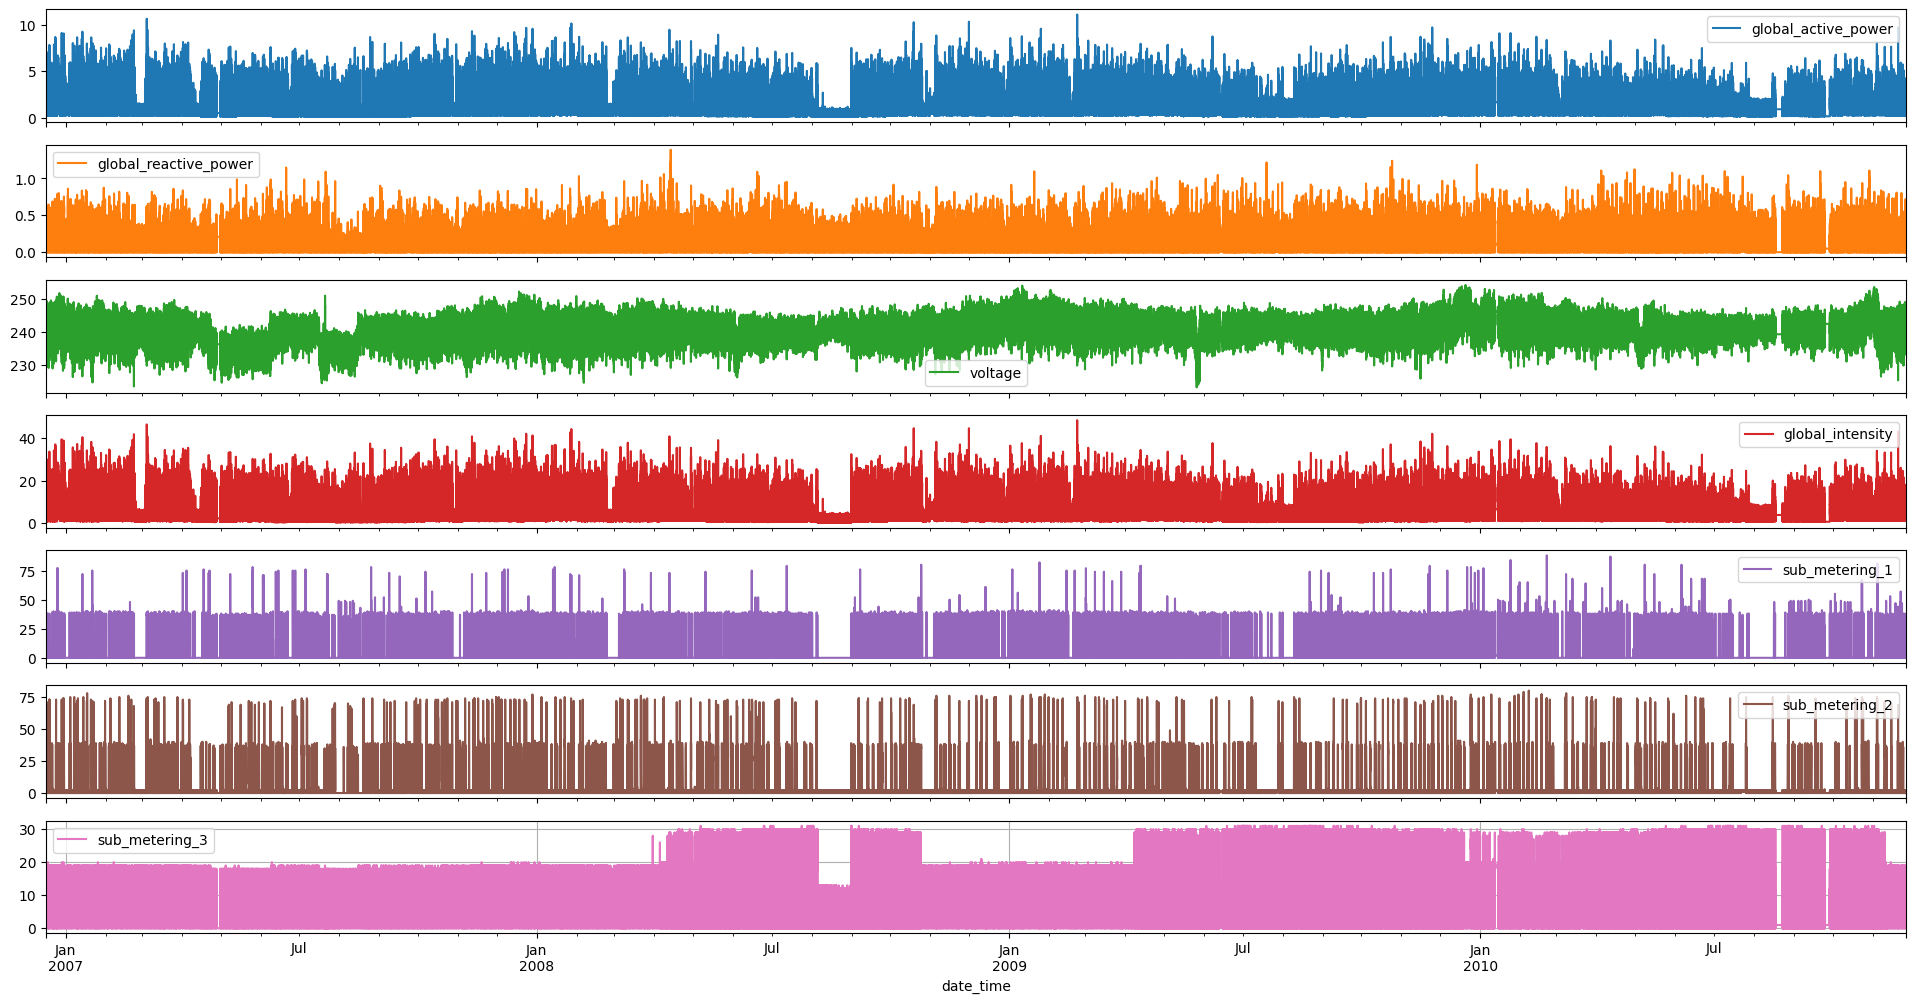

In [ ]:
# Line plots depicting the features with minute-based values in the power consumption dataset following the imputation of missing values
plt.figure(figsize=(60,16))
plt.suptitle('Line plots depicting the features with minute-based values in the power consumption dataset following the imputation of missing values', fontsize=24)
df_filled_missing_values.plot(subplots=True, figsize=(24, 12))
plt.grid(True)
plt.show()

Since the objective of the project is to forecast the average global active power for the upcoming week, I resampled the dataset to daily intervals, then aggregate and obtained these subplots:

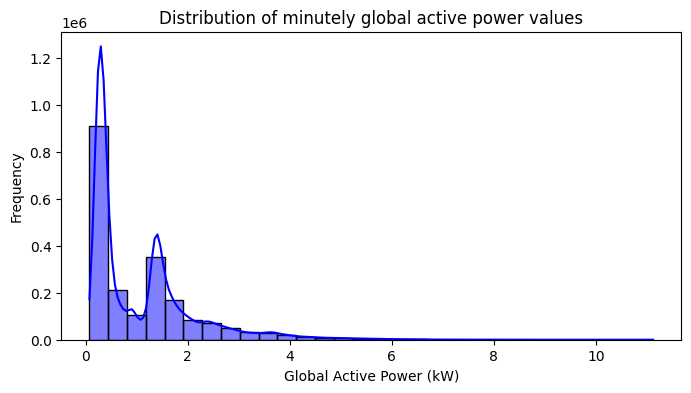

In [ ]:
# Plot the frequency distribution of the 'global_active_power' column.
plt.figure(figsize=(8, 4))
sns.histplot(df_filled_missing_values['global_active_power'], bins = 30, kde = True, color = 'blue')
plt.title('Distribution of minutely global active power values')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

+ The global_active_power distribution seems to display a bimodal pattern, suggesting the existence of two separate clusters of observations. Additionally, it exhibits a positive skew. This means that the outliers of the distribution are further towards the right. The reason for this could be winter spikes.

#### **Downsampling the per-minute observations of power consumption to daily totals - reducing the granularity of the minute-based data to a daily basis**

In [ ]:
df_resample_daily = df_filled_missing_values.resample('D').mean()
df_resample_daily.shape

(1442, 7)

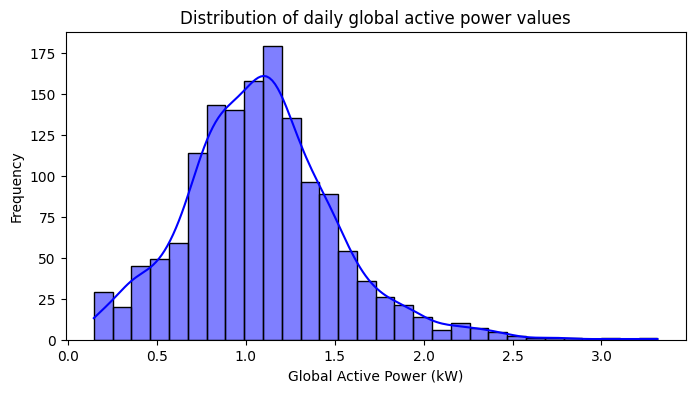

In [ ]:
# Plot the frequency distribution of the 'global_active_power' column.
plt.figure(figsize=(8, 4))
sns.histplot(df_resample_daily['global_active_power'], bins = 30, kde = True, color = 'blue')
plt.title('Distribution of daily global active power values')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

+ The distribution of global_active_power seems to approach a normal distribution after downsampling.

<Figure size 6000x1600 with 0 Axes>

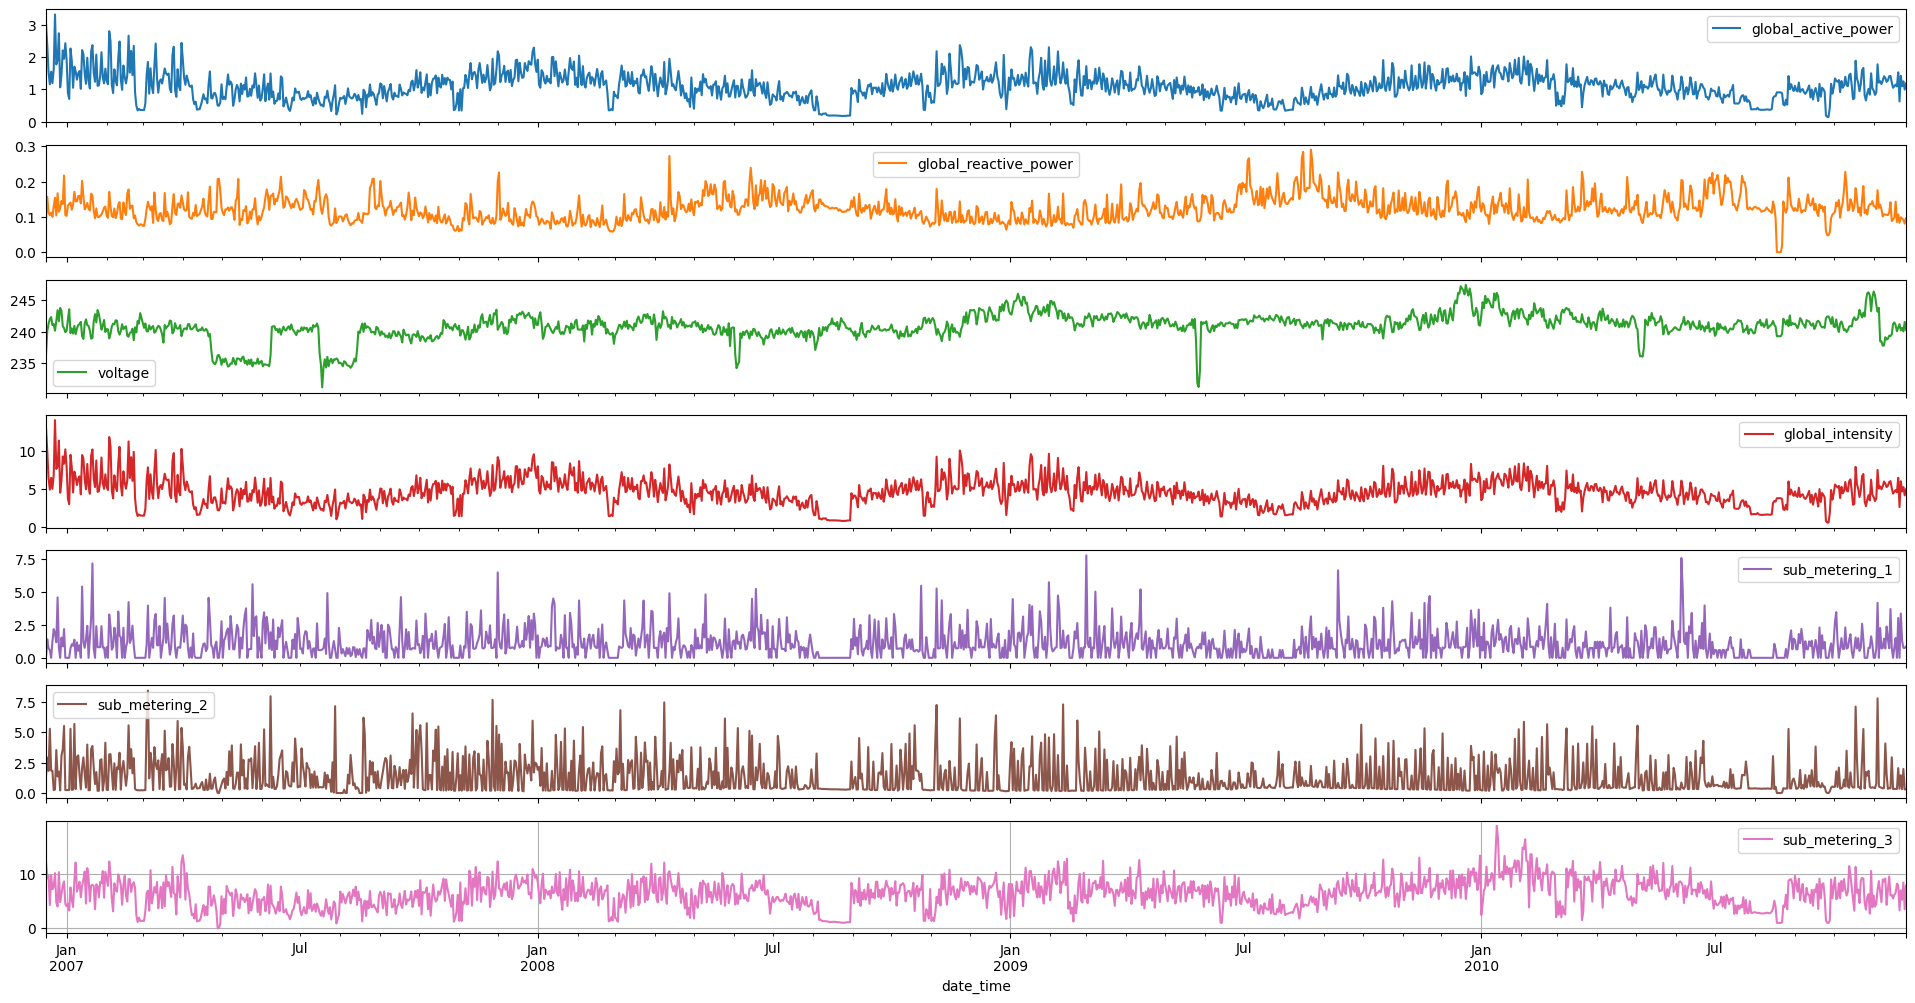

In [ ]:
# Line plots depicting the features with daily-based values in the power consumption dataset following the imputation of missing values
plt.figure(figsize=(60,16))
plt.suptitle('Line plots depicting the features with daily-based values in the power consumption dataset following the imputation of missing values', fontsize=24)
df_resample_daily.plot(subplots=True, figsize=(24, 12))
plt.grid(True)
plt.show()

+ Throughout the year, there are occasional spikes in energy, but the most significant spikes primarily occur during the winter seasons.

In [ ]:
df_resample_monthly = df_filled_missing_values.resample('M').mean()
df_resample_monthly.shape

(48, 7)

<Figure size 6000x1600 with 0 Axes>

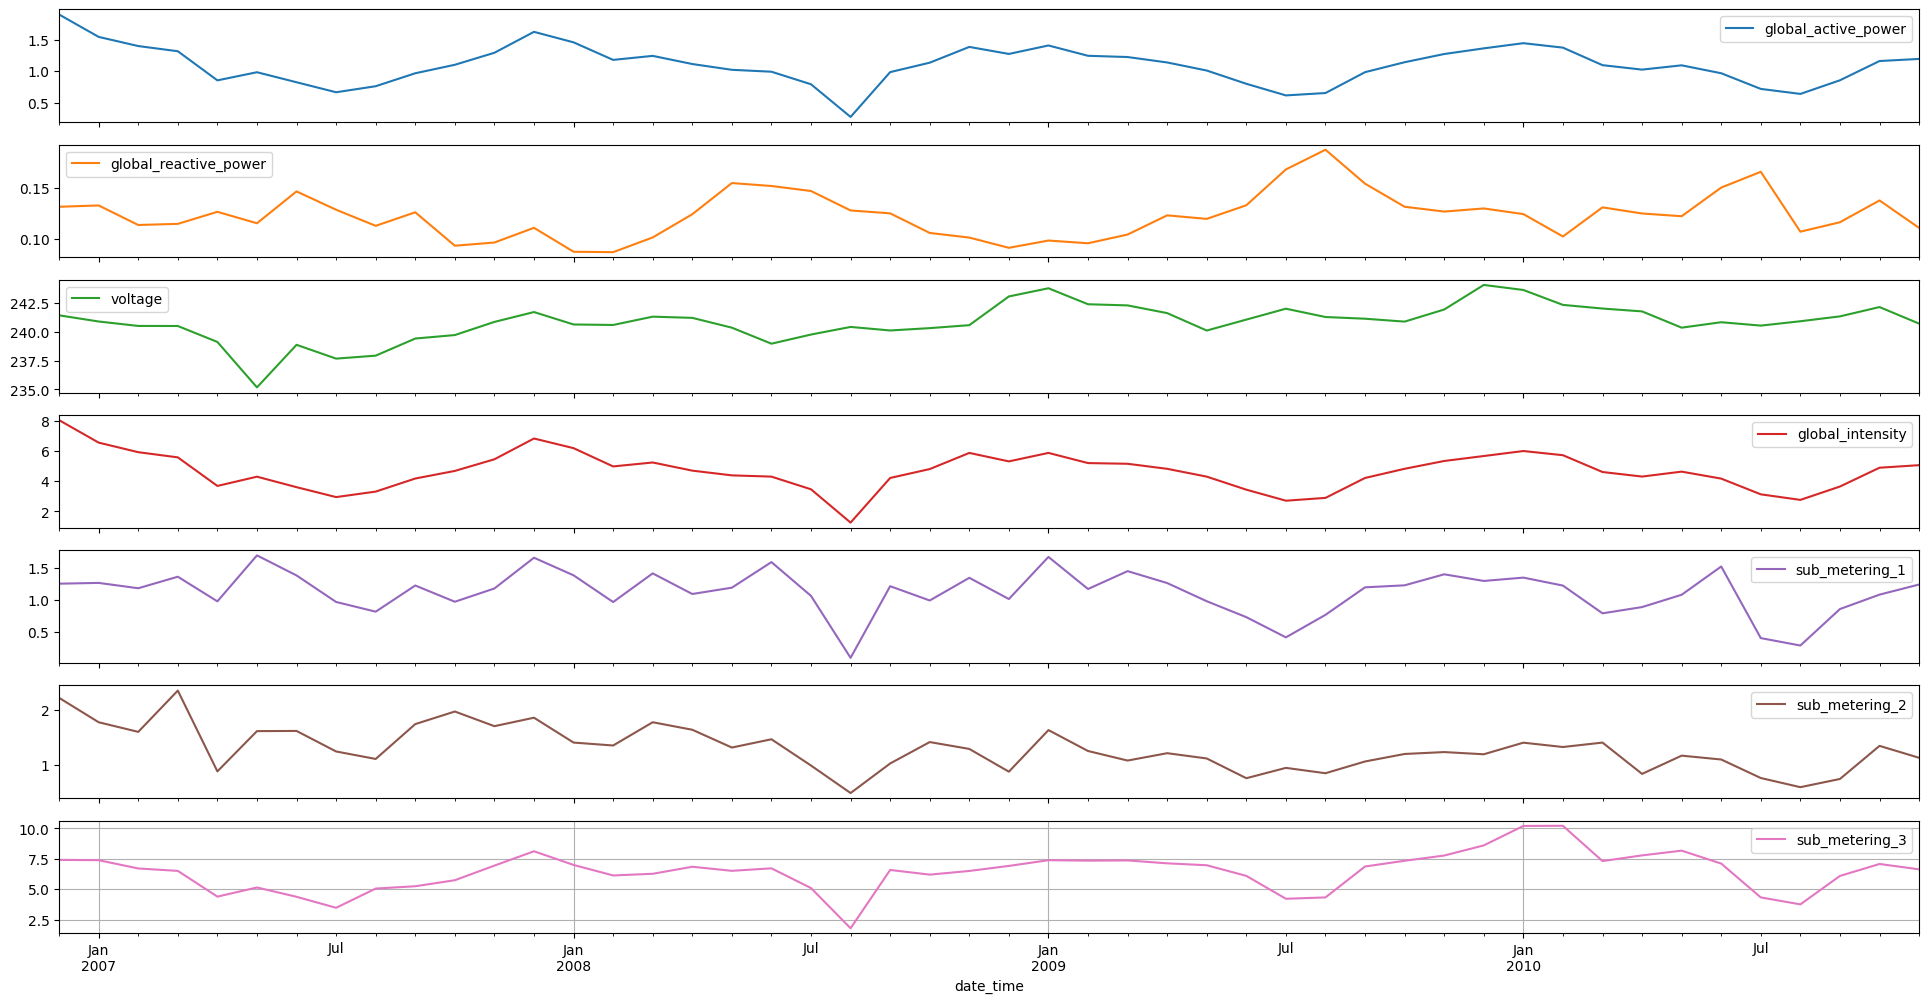

In [ ]:
# Line plots depicting the features with monthly-based values in the power consumption dataset following the imputation of missing values
plt.figure(figsize=(60,16))
plt.suptitle('Line plots depicting the features with monthly-based values in the power consumption dataset following the imputation of missing values', fontsize=24)
df_resample_monthly.plot(subplots=True, figsize=(24, 12))
plt.grid(True)
plt.show()

+ Each year, a seasonal trend is observed with a decrease from May to August. This is followed by an increase from August that continues until the end of the year (monthly seasonality).

In [ ]:
df_resample_weekly = df_filled_missing_values.resample('W').mean()
df_resample_weekly.shape

(207, 7)

<Figure size 6000x1600 with 0 Axes>

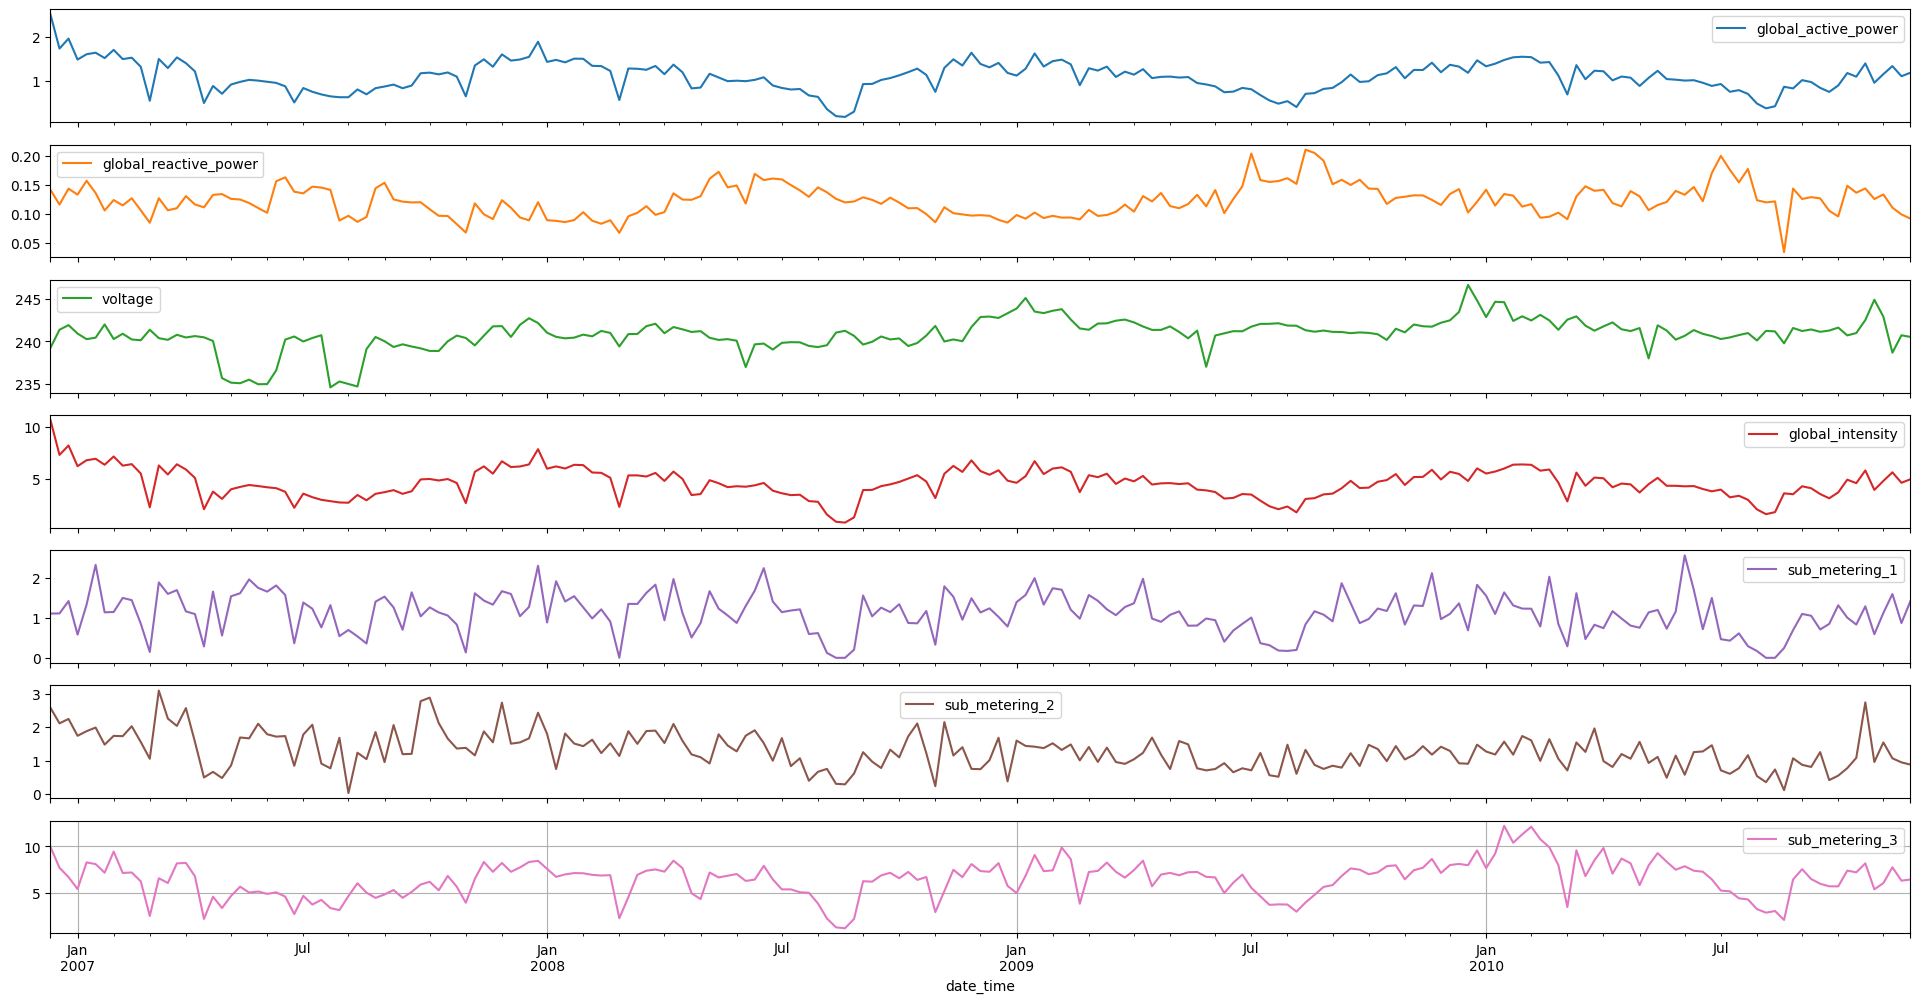

In [ ]:
# Line plots depicting the features with weekly-based values in the power consumption dataset following the imputation of missing values
plt.figure(figsize=(60,16))
plt.suptitle('Line plots depicting the features with weekly-based values in the power consumption dataset following the imputation of missing values', fontsize=24)
df_resample_weekly.plot(subplots=True, figsize=(24, 12))
plt.grid(True)
plt.show()

### **3.5 Handle duplicated values**

In [ ]:
df_resample_daily.duplicated().sum()  # first occurences are not counted as a duplicate.

4

In [ ]:
# Treat duplicated values as missing values and perform forward filling
df_filled_duplicates = df_resample_daily.mask(df_resample_daily.duplicated()).fillna(method='ffill')

In [ ]:
df_filled_duplicates.duplicated().sum()

4

There are still duplicates in the dataset, but they may be more consistent with the forward filling.

### **3.6 Outliers detection**

Winter peaks, holidays, etc.

**Outliers detection using box plots**

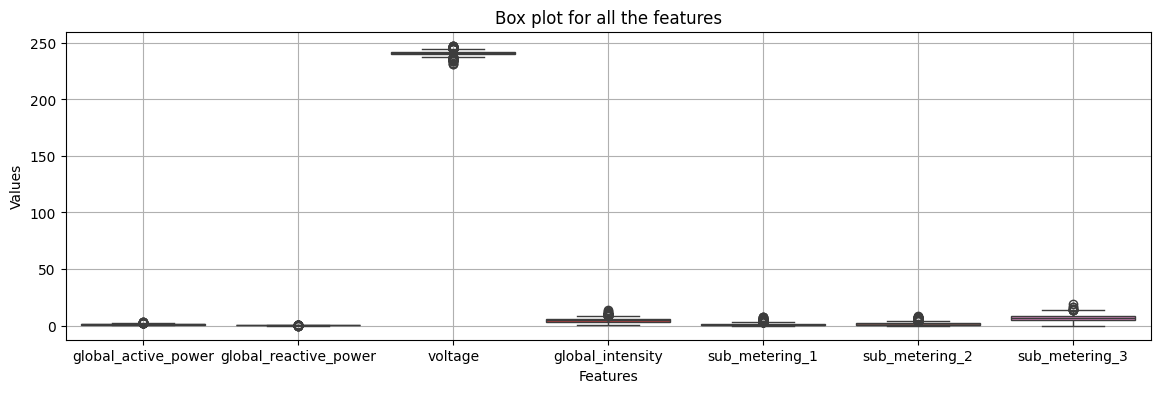

In [ ]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df_filled_duplicates)
plt.title('Box plot for all the features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

**Outliers detection using z-score**

In [ ]:
# Detect outliers using z-score.
z = np.abs(stats.zscore(df_filled_duplicates))
# z

In [ ]:
threshold = 3
# print(np.where(z > 3))

In [ ]:
# Perform outlier detection for each column (e.g., using z-score or IQR method)
# Let's use z-score as an example
outliers = df_filled_duplicates[(df_filled_duplicates - df_filled_duplicates.mean()).abs() > 3 * df_filled_duplicates.std()]

# Calculate the percentage of outliers in each column
outlier_percentages = outliers.count() / len(df_filled_duplicates) * 100
print(outlier_percentages)

global_active_power      0.832178
global_reactive_power    0.901526
voltage                  1.664355
global_intensity         0.970874
sub_metering_1           1.803051
sub_metering_2           1.595007
sub_metering_3           0.346741
dtype: float64


In [ ]:
df_filled = df_filled_duplicates

All the features show the presence of outliers in the dataset.

In [ ]:
# sns.distplot(df_filled.global_active_power,color='green')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_filled.global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_filled.global_active_power)))

Kurtosis of normal distribution: 1.3831221822348683
Skewness of normal distribution: 0.5941682876342886


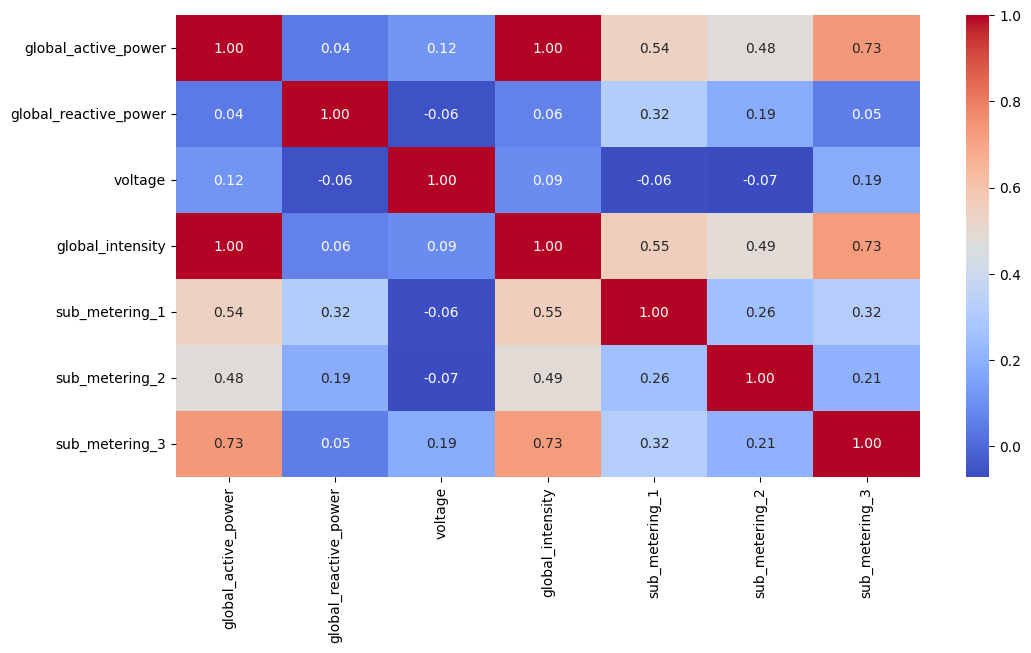

In [ ]:
# Visualization of the correlation matrix
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df_filled.corr(), annot=True, cmap="coolwarm", fmt=".2f")

# Display the plot
plt.show()

## **4. TRAIN-TEST SPLIT** to avoid data leakage

In [ ]:
# Compute split point
final_index = df_filled.shape[0]* 80 // 100

+ I conducted a train-test split, allocating 80% of the data for training and 20% for testing. I didn't shuffle the data during the process, as it is a time series dataset. Maintaining the chronological order is crucial for accurate analysis.

In [ ]:
# Split the data into train and test
X_train = df_filled.iloc[:final_index, :]
X_test = df_filled.iloc[final_index:, :]

In [ ]:
(X_train.shape, X_test.shape)

((1153, 7), (289, 7))

In [ ]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## **5. SCALE THE DATA (MINMAX SCALING)**

In [ ]:
# Define a function to scale the data
def data_scaling(train, test):

    scaler = MinMaxScaler().fit(train)

    return scaler.transform(train), scaler.transform(test), scaler

**Min-Max scaling**, also known as Min-Max normalization, transforms data into a specified range, typically [0, 1] or [-1, 1]. This method rescales the data so that the minimum value maps to 0 and the maximum value scales to 1 (or -1 if using the [-1, 1] range).

In [ ]:
# Scale the data
X_train_scaled, X_test_scaled, scaler = data_scaling(X_train, X_test)

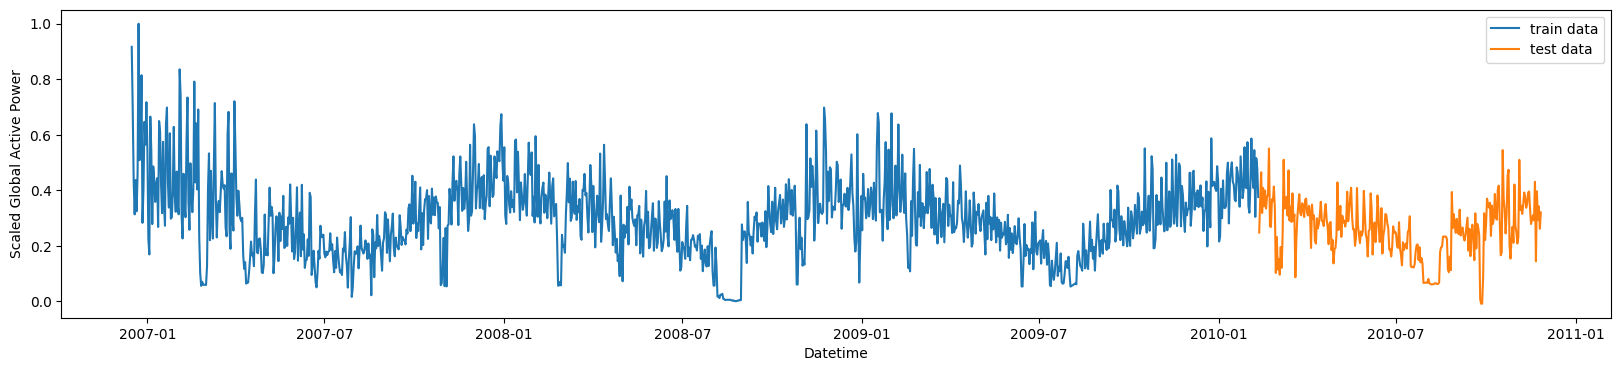

In [ ]:
# Visualize the scaled train and test data on a graph using the 'global_active_power' column
plt.figure(figsize=(20, 4))
plt.plot(X_train.index, X_train_scaled[:, 0], label='train data')
plt.plot(X_test.index, X_test_scaled[:, 0], label='test data')
plt.xlabel('Datetime')
plt.ylabel('Scaled Global Active Power')
plt.legend(loc='best')
plt.show()

## **6. CONVERT THE DATA INTO A SUPERVISED REGRESSION PROBLEM**

**Split the data (features and a target variable)**

The objective of this project is to utilize the input features recorded daily over the past week to forecast the average global active power for the upcoming week.

In [ ]:
# Define a function to convert the data into a supervised regression problem
def create_supervised_dataset(df):
    # Initialize lists to store input and output variables
    input_variables = []
    output_variable = []

    num_rows = df.shape[0]

    # Iterate through the dataframe rows
    for i in range(num_rows):
        # Define the final index of this pattern
        final_index = i + 7

        # Check if the final index is beyond the dataset
        if final_index > num_rows - 7:
            break

        # Gather input and output parts of the pattern
        X_pattern = df[i:final_index, 1:]
        y_pattern = df[final_index: final_index + 7, 0]

        # Append input and output variables to their respective lists
        input_variables.append(X_pattern)
        output_variable.append(y_pattern)

    # Convert lists to Numpy arrays and return
    return np.array(input_variables), np.mean(np.array(output_variable), axis=1)


In [ ]:
# Split the training and testing data into input variables and target variables
X_train, y_train = create_supervised_dataset(X_train_scaled)
X_test, y_test = create_supervised_dataset(X_test_scaled)

In [ ]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1140, 7, 6), (1140,), (276, 7, 6), (276,))

In [ ]:
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## **7. BUILD MODELS USING DEEP LEARNING ARCHITECTURES (CNN, LSTM, CNN-LSTM), MAKE PREDICTIONS, AND PERFORM EVALUATIONS ON THEM**

+ **Train Learning Curve:** Learning curve calculated from the training dataset that gives an idea of how well the model is learning.
+ **Validation Learning Curve:** Learning curve calculated from a **hold-out validation dataset** that gives an idea of how well the model is generalizing.

It is common to create dual learning curves for a machine learning model during training on both the training and validation datasets.

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
# Define a function to plot the model history
def plot_model_performance(history, model):

    # Plot model loss (MSE)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
all_metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()]

### **7.1 CNN Model without a dropout layer - using the relu activation function**

In [ ]:
# Architecture of the model
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=64, kernel_size=4, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=1))
model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dense(1))

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_CNN_2.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_CNN.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))

In [ ]:
# Display the model's architecture
print(model_CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             1600      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

88

In [ ]:
# Save the model
model_CNN.save('/content/drive/My Drive/best_models/best_model_CNN_2.h5')

# Load the best model
best_model_CNN_2 = load_model("best_model_CNN_2.h5")

#### **Evaluation of the model**

In [ ]:
CNN_scores = best_model_CNN_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 18.9325


#### **Plot training history of the model**

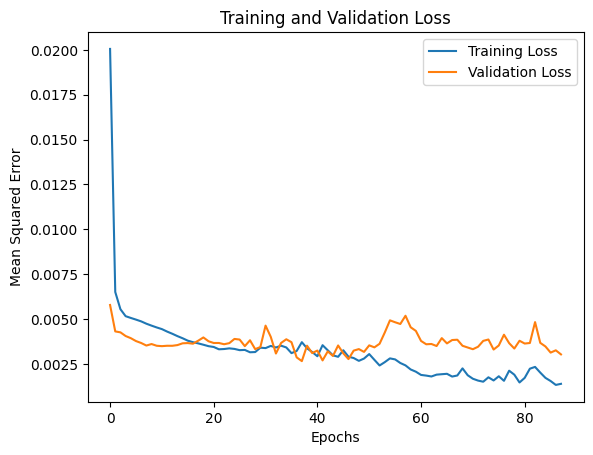

In [ ]:
plot_model_performance(history, 'CNN')

### **7.2 LSTM models**

The input to every LSTM layer must be three-dimensional. The three dimensions of this input are:

+ Samples: One sequence is one sample. A batch is comprised of one or more samples.
+ Time Steps: One time step is one point of observation in the sample.
+ Features: One feature is one observation at a time step.
This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

**Input:** 2-Dimensional data: samples, features

**Output:**
+ Input features (3-Dimensional data: samples, time steps (7 days), features),
+ Output feature (2-Dimensional data: samples, features)

#### **LSTM model without a dropout layer - using the tanh activation function**

**Model 1**

In [ ]:
# Architecture of the model
model_LSTM_no_drop = Sequential()
model_LSTM_no_drop.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_LSTM_no_drop.add(LSTM(64, activation='tanh', return_sequences=True))
model_LSTM_no_drop.add(LSTM(32, activation='tanh'))
model_LSTM_no_drop.add(Dense(64, activation='tanh'))
model_LSTM_no_drop.add(Dense(1))

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_LSTM_no_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_LSTM_no_drop_1.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_LSTM_no_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))

In [ ]:
# Display the model's architecture
print(model_LSTM_no_drop.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65793 (257.00 KB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

200

In [ ]:
model_LSTM_no_drop.save('/content/drive/My Drive/best_models/best_model_LSTM_no_drop_1.h5')

# Load the best model
best_model_LSTM_no_drop_1 = load_model("best_model_LSTM_no_drop_1.h5")

#### **Evaluation of the model**

In [ ]:
LSTM_scores = best_model_LSTM_no_drop_1.evaluate(X_test, y_test)

9/9 [==============================] - 2s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 18.6180


#### **Plot training history of the model**

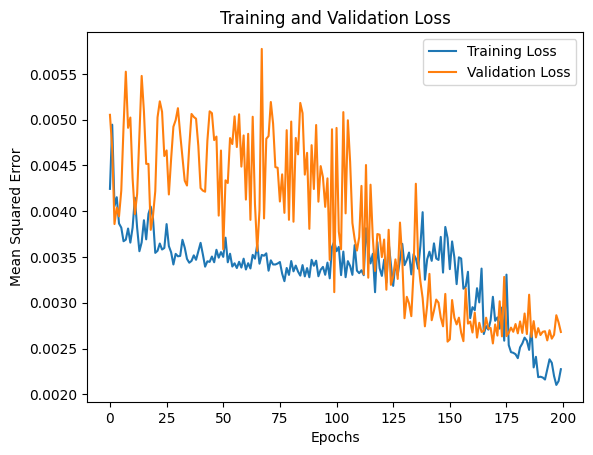

In [ ]:
plot_model_performance(history, 'LSTM without a dropout layer')

+ Observing significant oscillation in the training and validation loss graphs, I experimented with the model using a reduced learning rate.

#### **LSTM model without a dropout layer - using the tanh activation function - decreasing the learning rate**

**Model 2**

In [ ]:
# Architecture of the model
model_LSTM_no_drop = Sequential()
model_LSTM_no_drop.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_LSTM_no_drop.add(LSTM(64, activation='tanh', return_sequences=True))
model_LSTM_no_drop.add(LSTM(32, activation='tanh'))
model_LSTM_no_drop.add(Dense(64, activation='tanh'))
model_LSTM_no_drop.add(Dense(1))

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_LSTM_no_drop.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_LSTM_no_drop_3.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_LSTM_no_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))

In [ ]:
# Display the model's architecture
print(model_LSTM_no_drop.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65793 (257.00 KB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

129

In [ ]:
model_LSTM_no_drop.save('/content/drive/My Drive/best_models/best_model_LSTM_no_drop_3.h5')

# Load the best model
best_model_LSTM_no_drop_3 = load_model("best_model_LSTM_no_drop_3.h5")

#### **Evaluation of the model**

In [ ]:
LSTM_scores = best_model_LSTM_no_drop_3.evaluate(X_test, y_test)

9/9 [==============================] - 1s 5ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0417 - mean_absolute_percentage_error: 20.4177


#### **Plot training history of the model**

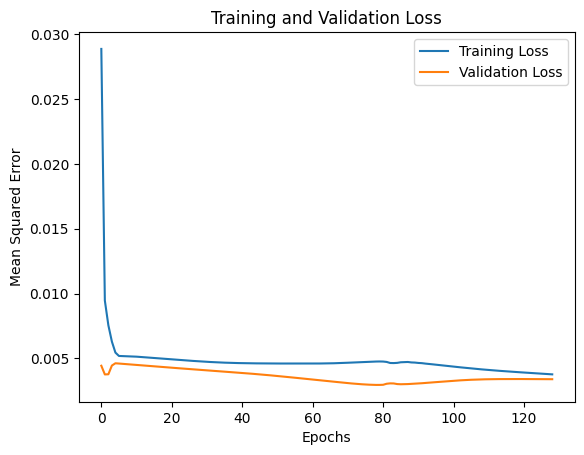

In [ ]:
plot_model_performance(history, 'LSTM without a dropout layer')

+ With a reduced learning rate, the plots for both training and validation loss become more stable.

#### **LSTM Model without a dropout layer - using the relu activation function**

**Model 3**

In [ ]:
# Architecture of the model
model_LSTM_no_drop = Sequential()
model_LSTM_no_drop.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_LSTM_no_drop.add(LSTM(64, activation='relu', return_sequences=True))
model_LSTM_no_drop.add(LSTM(32, activation='relu'))
model_LSTM_no_drop.add(Dense(64, activation='relu'))
model_LSTM_no_drop.add(Dense(1))

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_LSTM_no_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)
# model_LSTM_no_drop.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['rmse'], loss='mean_squared_error')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_LSTM_no_drop_2.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_LSTM_no_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))

In [ ]:
# Display the model's architecture
print(model_LSTM_no_drop.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 64)             18176     
                                                                 
 lstm_7 (LSTM)               (None, 7, 64)             33024     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65793 (257.00 KB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

200

In [ ]:
model_LSTM_no_drop.save('/content/drive/My Drive/best_models/best_model_LSTM_no_drop_2.h5')

# Load the best model
best_model_LSTM_no_drop_2 = load_model("best_model_LSTM_no_drop_2.h5")

#### **Evaluation of the model**

In [ ]:
LSTM_scores = best_model_LSTM_no_drop_2.evaluate(X_test, y_test)

9/9 [==============================] - 1s 5ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 17.5418


#### **Plot training history of the model**

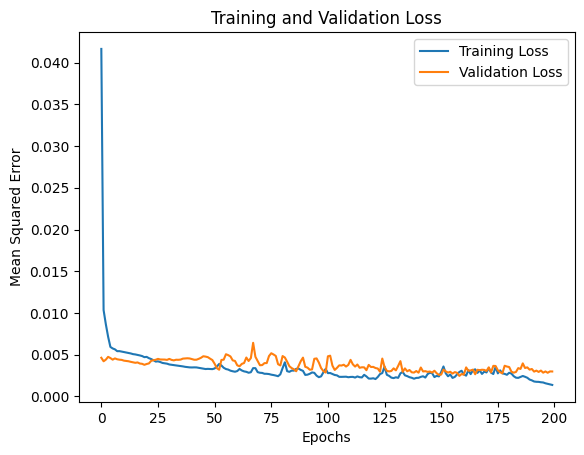

In [ ]:
plot_model_performance(history, 'LSTM without a dropout layer')

### **LSTM model with a dropout layer - using the relu activation function**

In [ ]:
# Architecture of the model
model_LSTM_with_drop = Sequential()
model_LSTM_with_drop.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_LSTM_with_drop.add(LSTM(80, activation='relu', return_sequences=True))
model_LSTM_with_drop.add(LSTM(20, activation='relu'))
model_LSTM_with_drop.add(Dropout(0.3))
model_LSTM_with_drop.add(Dense(20, activation='relu'))
model_LSTM_with_drop.add(Dense(1))

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_LSTM_with_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_LSTM_with_drop_1.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_LSTM_with_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))


In [ ]:
# Display the model's architecture
print(model_LSTM_with_drop.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7, 100)            42800     
                                                                 
 lstm_10 (LSTM)              (None, 7, 80)             57920     
                                                                 
 lstm_11 (LSTM)              (None, 20)                8080      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 109241 (426.72 KB)
Trainable params: 109

In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

188

In [ ]:
model_LSTM_with_drop.save('/content/drive/My Drive/best_models/best_model_LSTM_with_drop_1.h5')

# Load the best model
best_model_LSTM_with_drop_1 = load_model("best_model_LSTM_with_drop_1.h5")

#### **Evaluation of the model**

In [ ]:
LSTM_scores = best_model_LSTM_with_drop_1.evaluate(X_test, y_test)

9/9 [==============================] - 1s 5ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 19.9659


#### **Plot training history of the model**

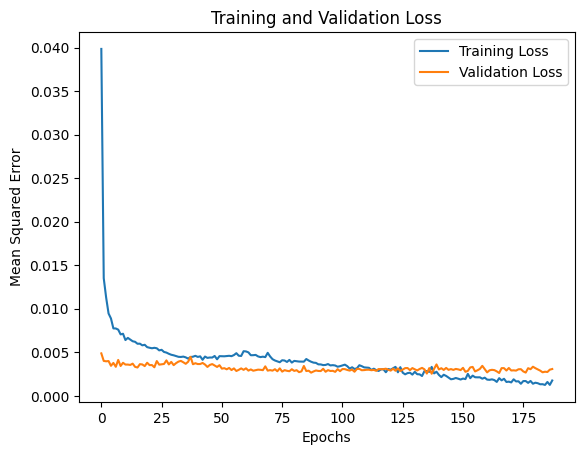

In [ ]:
plot_model_performance(history, 'LSTM with a dropout layer')

### **7.3 CNN-LSTM Model**

Experiments have shown that CNN-LSTM hybrid networks, which linearly combine convolutional neural network (CNN), long short-term memory (LSTM) and deep neural network (DNN), can extract irregular features of electric power consumption. The CNN layer is used to reduce the spectrum of spatial information, the LSTM layer is suitable for modeling temporal information, the DNN layer generates a predicted time series. The CNN-LSTM hybrid approach almost completely predicts power consumption.

https://link.springer.com/chapter/10.1007/978-3-030-03493-1_50

It is helpful to think of this architecture as defining two sub-models: the CNN Model for feature extraction and the LSTM Model for interpreting the features across time steps.

https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

In [ ]:
# Convert the training data to a 4-dimensional format.
X_train = X_train.reshape(-1, X_train.shape[1], 1, X_train.shape[2])

# Convert the testing data to a 4-dimensional format.
X_test = X_test.reshape(-1, X_test.shape[1], 1, X_test.shape[2])

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1140, 7, 1, 6), (1140,), (276, 7, 1, 6), (276,))

#### **CNN-LSTM model without a dropout layer - using the relu activation function**

**Model 1**

In [ ]:
# Architecture of the model
model_CNN_LSTM_no_drop = Sequential()
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(7,1,6))))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu')))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu')))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Flatten()))
model_CNN_LSTM_no_drop.add(LSTM(80, activation='relu', return_sequences=True))
model_CNN_LSTM_no_drop.add(LSTM(50, activation='relu', return_sequences=True))
model_CNN_LSTM_no_drop.add(LSTM(20, activation='relu'))
model_CNN_LSTM_no_drop.add(Dense(20))
model_CNN_LSTM_no_drop.add(Dense(1))


In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_CNN_LSTM_no_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_CNN_LSTM_no_drop_1.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_CNN_LSTM_no_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))


In [ ]:
# Display the model's architecture
print(model_CNN_LSTM_no_drop.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 7, 1, 64)          448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 7, 1, 64)          0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 7, 1, 32)          2080      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 7, 1, 32)          0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 7, 1, 32)         

In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

132

In [ ]:
model_CNN_LSTM_no_drop.save('/content/drive/My Drive/best_models/best_model_CNN_LSTM_no_drop_1.h5')

# Load the best model
best_model_CNN_LSTM_no_drop_1 = load_model("best_model_CNN_LSTM_no_drop_1.h5")

#### **Evaluation of the model**

In [ ]:
CNN_LSTM_scores = best_model_CNN_LSTM_no_drop_1.evaluate(X_test, y_test)

9/9 [==============================] - 1s 5ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 19.1502


#### **Plot training history of the model**

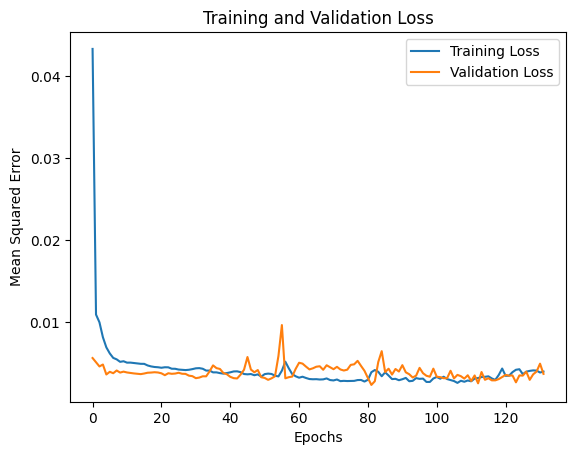

In [ ]:
plot_model_performance(history, 'CNN LSTM without a dropout layer')

**Model 2**

In [ ]:
# Architecture of the model
model_CNN_LSTM_no_drop = Sequential()
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(7,1,6))))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu')))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu')))
model_CNN_LSTM_no_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_CNN_LSTM_no_drop.add(TimeDistributed(Flatten()))
model_CNN_LSTM_no_drop.add(LSTM(80, activation='relu', return_sequences=True))
model_CNN_LSTM_no_drop.add(LSTM(50, activation='relu', return_sequences=True))
model_CNN_LSTM_no_drop.add(LSTM(20, activation='relu'))
model_CNN_LSTM_no_drop.add(Dense(20))
model_CNN_LSTM_no_drop.add(Dense(1))


In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Compile the model
model_CNN_LSTM_no_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=all_metrics)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_model_CNN_LSTM_no_drop_3.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

# Fit the model and utilize callbacks during model training
# Model is saved at the end of every epoch, if it's the best seen so far.
history = model_CNN_LSTM_no_drop.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[checkpoint, early_stopping], shuffle=False)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))


In [ ]:
# # Display the model's architecture
# print(model_CNN_LSTM_no_drop.summary())

In [ ]:
# Calculate the number of epochs executed
len(history.history['val_loss'])

110

In [ ]:
model_CNN_LSTM_no_drop.save('/content/drive/My Drive/best_models/best_model_CNN_LSTM_no_drop_3.h5')

# Load the best model
best_model_CNN_LSTM_no_drop_3 = load_model("best_model_CNN_LSTM_no_drop_3.h5")

#### **Evaluation of the model**

In [ ]:
CNN_LSTM_scores = best_model_CNN_LSTM_no_drop_3.evaluate(X_test, y_test)

9/9 [==============================] - 2s 11ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 18.9551


#### **Plot training history of the model**

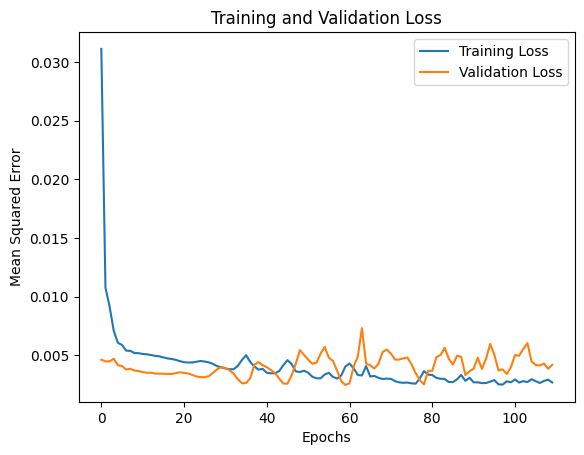

In [ ]:
plot_model_performance(history, 'CNN LSTM without a dropout layer')

## **8. BUILD A MODEL USING MULTIPLE LINEAR REGRESSION (MLR), MAKE PREDICTIONS AND PERFORM EVALUATIONS ON THEM**

### **8.1 Train-Test Split** to avoid data leakage

In [ ]:
# Compute split point
final_index = df_filled.shape[0]* 80 // 100

In [ ]:
# Split the data into train and test
X_train = df_filled.iloc[:final_index, :]
X_test = df_filled.iloc[final_index:, :]

In [ ]:
(X_train.shape, X_test.shape)

((1153, 7), (289, 7))

In [ ]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### **8.2 Scale the data (MinMax scaling)**

In [ ]:
# Define a function to scale the data
def data_scaling(train, test):

    scaler = MinMaxScaler().fit(train)

    return scaler.transform(train), scaler.transform(test), scaler

In [ ]:
# Scale the data
X_train, X_test, scaler = data_scaling(X_train, X_test)

In [ ]:
# Define scoring metrics
scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error')

In [ ]:
X_train = X_train[:1140]
X_test = X_test[:276]

In [ ]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1140, 7), (1140,), (276, 7), (276,))

### **8.3 Evaluation of the model**

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [ ]:
# Initialize a Linear Regression model
model_LR = LinearRegression()

In [ ]:
# Record the start time
t0 = time.time()

In [ ]:
# Memory profiling
%%memit

# Fit the model on the entire training set
model_LR.fit(X_train, y_train)

# Make predictions on the test set
y_pred_LR = model_LR.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_LR)
rmse = root_mean_squared_error(y_test, y_pred_LR)
mae = mean_absolute_error(y_test, y_pred_LR)
mape = mean_absolute_percentage_error(y_test, y_pred_LR)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

# Record the end time
tF = time.time()

# Calculate and print the time taken for training
print('Time to train = %.3f seconds' % (tF - t0))

Mean Squared Error: 0.0044030281124398185
Root Mean Squared Error: 0.06635531713766289
Mean Absolute Error: 0.05034113041821463
Mean Absolute Percentage Error 0.2930354772647622
Time to train = 1.651 seconds
peak memory: 2284.14 MiB, increment: 0.00 MiB


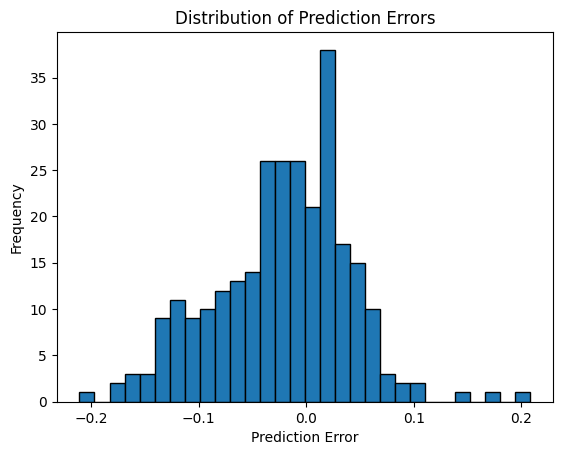

In [ ]:
# Calculate errors
errors = y_test - y_pred_LR

# Create histogram
plt.hist(errors, bins=30, edgecolor='black')

# Add title and labels
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

# Show plot
plt.show()


+ The distribution of prediction errors shows asymmetry, suggesting that the model's errors may be systematic rather than random. Additionally, the influence of outliers is noticeable.

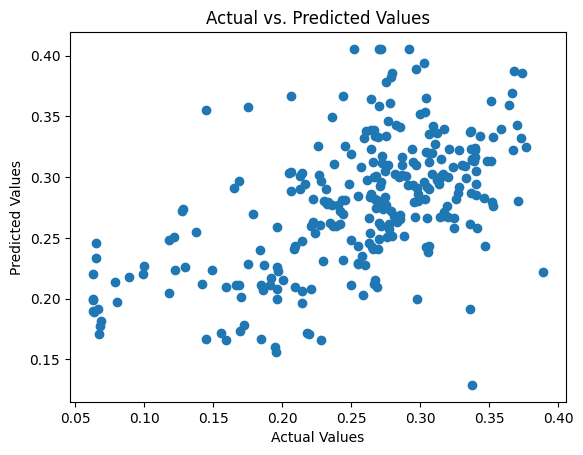

In [ ]:
# Plot actual vs. predicted values
plt.scatter(y_test, y_pred_LR)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(y_test, y_pred_LR)[0, 1]
correlation

0.5536950875601663

+ There is a moderate correlation between the actual and predicted values, indicating our model makes fairly accurate predictions. The data points are dispersed. The influence of outliers is noticeable.


## **9. Best Performance Metrics of Four Models at Project Conclusion**

**CNN without a dropout layer:**
+ Exhibits the least memory usage.
+ Achieves shorter training time compared to other neural network architectures.

**LSTM without a dropout layer:**
+ Yields the best Mean Absolute Percentage Error (MAPE).

**CNN-LSTM without a dropout layer:**
+ Provides the best performance in terms of Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

**Multiple Linear Regression:**
+ Stands out as the overall quickest model.

## **10. Future Work**

The future work for this study can include the following:
+ Evaluating these models by experimenting with various datasets, such as Electricity Consumption in a Sample of London Households: https://data.london.gov.uk/blog/electricity-consumption-in-a-sample-of-london-households/

+ Exploring other hybrid deep learning architectures such as LSTM-CNN, ConvLSTM2D, and BiLSTM,

+ Implementing nonlinear extensions to enhance the Multiple Linear Regression model.

### **REFERENCES**

 + UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

 + T. Y. Kim, S. B. Cho. Predicting residential energy consumption using CNN-LSTM neural networks. Energy, vol. 182, pp. 72-81, 2019. https://doi.org/10.1016/j.energy.2019.05.230

+ F. U. M. Ullah et al. Short-Term Prediction of Residential Power Energy Consumption via CNN and Multi-Layer Bi-Directional LSTM Networks. IEEE Access, vol. 8, pp. 123369-123380, 2019.  https://doi.org/10.1109/ACCESS.2019.2963045

+ Z. Zhou, C. Qiu, and Y. Zhang. A comparative analysis of linear regression, neural networks and random forest regression for predicting air ozone employing soft sensor models. Scientific Reports (Nature), vol. 13, 2023. https://doi.org/10.1038/s41598-023-49899-0

+ N. E. Bezzar et al. Data analysis-based time series forecast for managing household electricity consumption. Demonstratio Mathematica, vol. 55, pp. 900-921, 2022. https://doi.org/10.1515/dema-2022-0176

+ E. M. D. M. Sarmento et al. Forecasting energy power consumption using federated learning in edge computing devices. Internet of Things, vol. 25, 2024. https://doi.org/10.1016/j.iot.2023.101050

+ J. W. Osborne, E. Waters. Four assumptions of multiple regression that researchers should always test. Practical Assessment, Research, and Evaluation, vol. 8, Article 2, 2019. https://doi.org/10.7275/r222-hv23

+ https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

+ https://github.com/iam-armanahmed/household-electric-power-consumption/blob/master/EDA_and_Model.ipynb

+ https://scikit-learn.org/stable/
https://scikit-learn.org/stable/index.html

+ https://www.tensorflow.org

+ https://colah.github.io/posts/2015-08-Understanding-LSTMs/

+ https://medium.com/towards-data-science/neural-networks-forward-pass-and-backpropagation-be3b75a1cfcc

+ https://www.tutorialspoint.com/save-and-load-models-in-tensorflow